# "A breath of fresh air" - ML model training notebook

In [2]:
# import libraries and tools
import pandas as pd
import numpy as np
import missingno as msno
import metpy.calc
from metpy.units import units

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, fbeta_score, make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from variable_names import vars_drop

import preprocessing_pipeline as prepro
import feature_engineering as feng

import warnings
warnings.filterwarnings('ignore')

# eye candy plots
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
# source https://github.com/dhaitz/matplotlib-stylesheets


#### Get data and cleaning

In [3]:
# get data
df = pd.read_csv('data/Train.csv')
## Throw out unwanted variables
df.drop(vars_drop, axis=1, inplace=True)
# Convert wind cartesional components to magnitude and direction 
df = feng.create_wind(df)
# Convert time to datetime and create day-of-week column
df = feng.time_features(df)
# Convert target from float into category labels
df = feng.create_target_labels(df)
## Throw out variables with less than 15 features
df.dropna(thresh=15, inplace=True)

# Create prior features
df = feng.prior_features(df)

#### Define preprocessor and split data

In [4]:
non_qnt_cols = ['Place_ID','Date','Place_ID X Date','target','target_cat']
qnt_cols = [col for col in df.columns.to_list() if col not in non_qnt_cols]
cat_cols = ['Place_ID','weekday']

### Define the preprocessor

preprocessor = prepro.make_pipeline(qnt_cols,cat_cols)

## To make time spit, first drop numerical target and unnecessary categories
## Keep target_cat as part of the dataframe

df.drop(['Place_ID X Date','target'], axis=1, inplace=True)
#Perform test train split for time series data
X_train, X_test, y_train, y_test = prepro.test_train_time_split(df,
                                                         target_name='target_cat',
                                                         date_name='Date',
                                                         test_size=0.3)

print(f'X_train shape is{X_train.shape}, y_train shape is {y_train.shape}')
print(f'X_test shape is{X_test.shape}, y_test shape is {y_test.shape}')

X_train shape is(21269, 29), y_train shape is (21269,)
X_test shape is(9115, 29), y_test shape is (9115,)


## Rebalance classes in new dataset

In [5]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

val_cts = y_train.value_counts() # the current counts of each class
vc_min = val_cts.min() # the minimun class

# reduce the larger classes so that they are halfway to min
vc_rus = (val_cts - vc_min)//2 + vc_min 
rus = RandomUnderSampler(sampling_strategy={0: vc_rus[0], 1: vc_rus[1], 2: vc_rus[2]})

# oversample the smaller classes so that they equal the max class
ros = RandomOverSampler()

X_res, y_res = rus.fit_resample(X_train,y_train)
X_res, y_res = ros.fit_resample(X_res,y_res)

In [6]:
y_res.value_counts()

0    7966
1    7966
2    7966
Name: target_cat, dtype: int64

In [7]:
def print_results(y_true,y_pred):
    print(f"Average class-weighted f-beta score is {fbeta_score(y_true,y_pred,beta=2,average='weighted'):.2f}")
    print('-------'*10)
    labels = [0,1,2]
    conf = confusion_matrix(y_true,y_pred,labels=labels)
    

    sns.heatmap(conf,annot=True,fmt='g', xticklabels=labels, yticklabels=labels);
    print(classification_report(y_true, y_pred,labels=labels))


## Make a scorer for the gridsearch
fbeta2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')


## Baseline

Average class-weighted f-beta score is 0.41
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2274
           1       0.00      0.00      0.00      2365
           2       0.49      1.00      0.66      4476

    accuracy                           0.49      9115
   macro avg       0.16      0.33      0.22      9115
weighted avg       0.24      0.49      0.32      9115



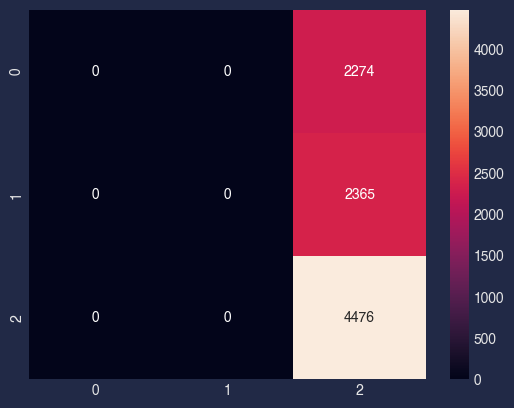

In [8]:
### Real basline model
y_pred = [2 for _ in y_test]

## print the results
print_results(y_test,y_pred);

#### Logistic Regression model

Average class-weighted f-beta score is 0.69
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.73      0.68      2274
           1       0.47      0.45      0.46      2365
           2       0.84      0.79      0.81      4476

    accuracy                           0.69      9115
   macro avg       0.65      0.66      0.65      9115
weighted avg       0.69      0.69      0.69      9115



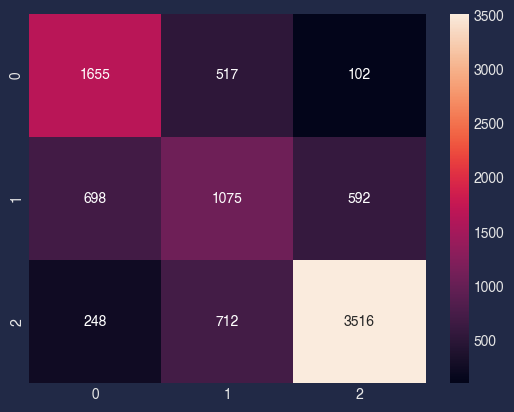

In [17]:
param_grid = {'log_reg__max_iter': [1000,]} 
## NOTE! Your paramgrid for model parameters must have the name of your model
## in the pipeline separated by two underscores. See here:
## log_reg + __ + parameter name

### Create a pipeline with the chosen baseline model and preprocessor
base_log = Pipeline([
    ('preprocessor', preprocessor),
    ('log_reg', LogisticRegression())
])


#Create a gridsearch for cross validation
gs_baseline = GridSearchCV(base_log, param_grid=param_grid, cv=5, scoring=fbeta2_scorer, 
                           verbose=0, n_jobs=-1)


## Fit the model using gridsearch and get best model
gs_baseline.fit(X_res, y_res);
best_model = gs_baseline.best_estimator_

## Make predictions on test set
y_pred = best_model.predict(X_test);

## print the results
print_results(y_test,y_pred);


#### Random forest model


Average class-weighted f-beta score is 0.65
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.59      0.69      0.64      2274
           1       0.47      0.31      0.37      2365
           2       0.76      0.83      0.80      4476

    accuracy                           0.66      9115
   macro avg       0.61      0.61      0.60      9115
weighted avg       0.64      0.66      0.65      9115



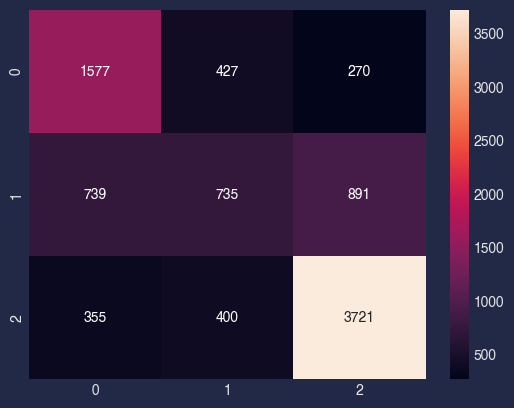

In [9]:
param_grid = {'rmf__n_estimators': range(10,200,5),
              'rmf__max_depth': [None,] + list(range(10,100,5)),
              'rmf__min_samples_leaf': range(1,10),
              'rmf__max_features': ("sqrt","log2",2,5,10)}

### Create a pipeline with the chosen baseline model and preprocessor
rmfor = Pipeline([
    ('preprocessor', preprocessor),
    ('rmf', RandomForestClassifier())
])


#Create a gridsearch for cross validation
rs_rmfor = RandomizedSearchCV(rmfor, param_distributions=param_grid, cv=5, scoring=fbeta2_scorer, 
                           verbose=0, n_jobs=-1, n_iter=20)


## Fit the model using gridsearch and get best model
rs_rmfor.fit(X_res, y_res);
best_model = rs_rmfor.best_estimator_

## Make predictions on test set
y_pred = best_model.predict(X_test);

## print the results
print_results(y_test,y_pred);

In [13]:
### random forest params
best_model['rmf']

RandomForestClassifier(max_features=5, n_estimators=180)